In [24]:
!nvidia-smi


Wed Dec 11 17:00:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              52W / 400W |   2501MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [25]:
!pip install cvzone
!pip install mediapipe
!pip install tensorflow

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report




In [28]:
# Check if GPU is being used
if tf.test.gpu_device_name():
    print(f"TensorFlow is using GPU: {tf.test.gpu_device_name()}")
else:
    print("TensorFlow is not using the GPU.")

TensorFlow is using GPU: /device:GPU:0


In [29]:
#paths
project_path = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/"
michael_data_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/"
landmarks_only_folder = "/content/drive/MyDrive/50.035 Computer Vision Group Assignment/Data (Combined)/cropped (Mitchel & Ad)/Landmarks (black)"

data_folder = landmarks_only_folder #note to nada: this path currently points at landmarks only, feel free to change if you want to train on diff dataset

In [30]:
#create csv - note: u only need to run this once btw if u keep retraining the model
csv_path = os.path.join(michael_data_folder,'_landmarks_metadata.csv') #note to nada: change this if ur not training landmarks only
data = []

for filename in os.listdir(data_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        label = filename.split(" (")[0]
        img_path = os.path.join(data_folder, filename)
        data.append({"img_path": img_path, "label": label})

df = pd.DataFrame(data)
print(df.head())

unique_labels = sorted(df['label'].unique())
label_map = {label: idx for idx, label in enumerate(unique_labels)}
df['numeric_label'] = df['label'].map(label_map)
df = df.drop(columns='label')

df.to_csv(csv_path, index=False)
print("DataFrame created and saved successfully!")



                                            img_path  label
0  /content/drive/MyDrive/50.035 Computer Vision ...  tur_N
1  /content/drive/MyDrive/50.035 Computer Vision ...  tur_N
2  /content/drive/MyDrive/50.035 Computer Vision ...  tur_N
3  /content/drive/MyDrive/50.035 Computer Vision ...  tur_N
4  /content/drive/MyDrive/50.035 Computer Vision ...  tur_N
DataFrame created and saved successfully!


In [31]:
# Load the metadata CSV
metadata = pd.read_csv(csv_path)

# Ensure the 'img_path' column contains full paths to images
metadata['img_path'] = metadata['img_path'].apply(lambda x: os.path.join(data_folder, x))
metadata.head()

,img_path,numeric_label
0,/content/drive/MyDrive/50.035 Computer Vision ...,38
1,/content/drive/MyDrive/50.035 Computer Vision ...,38
2,/content/drive/MyDrive/50.035 Computer Vision ...,38
3,/content/drive/MyDrive/50.035 Computer Vision ...,38
4,/content/drive/MyDrive/50.035 Computer Vision ...,38


In [32]:
# Split the metadata into training, validation, and test sets
train_df = metadata.sample(frac=0.8, random_state=42)  # 80% training
remaining_df = metadata.drop(train_df.index)
val_df = remaining_df.sample(frac=0.5, random_state=42)  # 50% of remaining = 10% overall
test_df = remaining_df.drop(val_df.index)  # Remaining 10% for test

# Convert 'numeric_label' to string for compatibility with class_mode='categorical'
train_df['numeric_label'] = train_df['numeric_label'].astype(str)
val_df['numeric_label'] = val_df['numeric_label'].astype(str)
test_df['numeric_label'] = test_df['numeric_label'].astype(str)



# # Create ImageDataGenerator instances
# train_datagen = ImageDataGenerator(
#     rescale=1.0 / 255.0,  # Normalize pixel values
#     validation_split=0.2
# )
# val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# train_generator = train_datagen.flow_from_dataframe(
#     train_df,
#     x_col='img_path',
#     y_col='numeric_label',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=True
# )

# val_generator = val_datagen.flow_from_dataframe(
#     val_df,
#     x_col='img_path',
#     y_col='numeric_label',
#     target_size=(224, 224),
#     batch_size=32,
#     class_mode='categorical',
#     shuffle=False
# )



In [33]:
# Paths and labels from the DataFrame
train_paths = train_df['img_path'].values
train_labels = tf.keras.utils.to_categorical(train_df['numeric_label'].astype(int).values)
val_paths = val_df['img_path'].values
val_labels = tf.keras.utils.to_categorical(val_df['numeric_label'].astype(int).values)
test_paths = test_df['img_path'].values
test_labels = tf.keras.utils.to_categorical(test_df['numeric_label'].astype(int).values)

# Preprocessing function for loading and resizing images
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to target size
    image = image / 255.0  # Normalize pixel values
    return image, label

# Create tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Optimize datasets
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [34]:
# Load mobilenet and modify it for the dataset
num_classes = 48

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers[-5:]:  # unfreeze last X layers
    layer.trainable = True


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 121s 110ms/step - accuracy: 0.7985 - loss: 0.9797 - val_accuracy: 0.9937 - val_loss: 0.0324
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9954 - loss: 0.0171 - val_accuracy: 0.9969 - val_loss: 0.0157
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 1.0000 - loss: 6.9169e-04 - val_accuracy: 0.9979 - val_loss: 0.0130
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 1.0000 - loss: 2.2753e-04 - val_accuracy: 0.9979 - val_loss: 0.0136
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 1.0000 - loss: 1.5612e-04 - val_accuracy: 0.9979 - val_loss: 0.0135
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 1.0000 - loss: 1.0022e-04 - val_accuracy: 0.9979 - val_loss: 0.0134
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 1.0000 - loss: 8.4832e-05 - val_accuracy: 0.9979 - val_loss: 0.0126
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 1.

In [36]:
# evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Set Accuracy: {test_accuracy}")


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9984 - loss: 0.0223
Test Set Accuracy: 0.9989528656005859


30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step


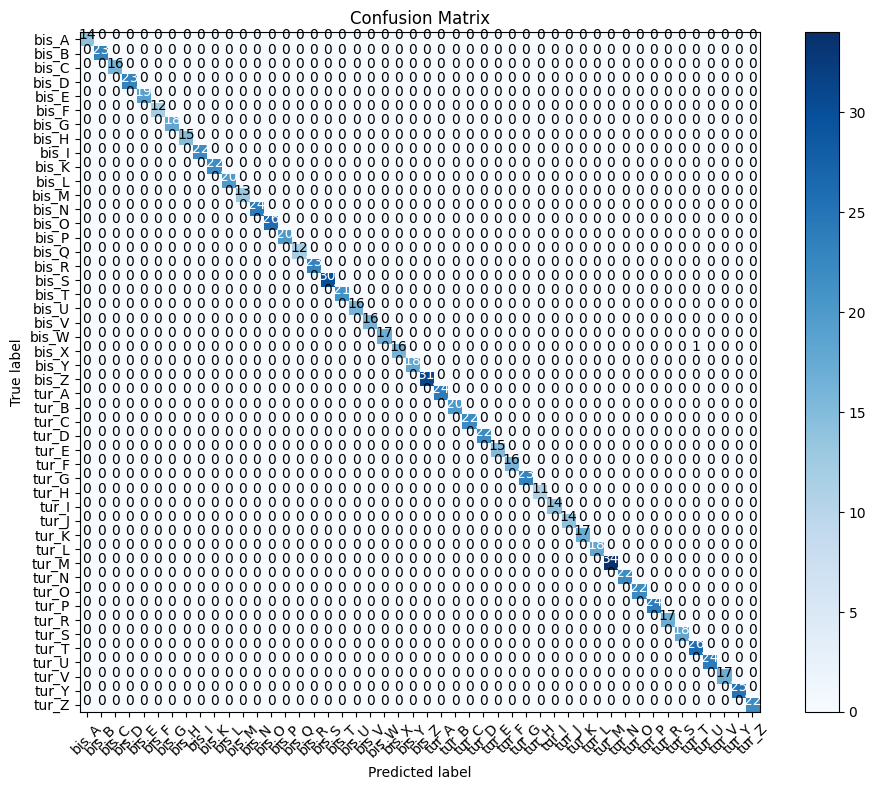

In [37]:
def get_labels(dataset):
    labels = []
    for _, label in dataset:
        labels.append(label.numpy())
    return np.concatenate(labels)

y_true = get_labels(test_dataset)

y_pred = np.argmax(model.predict(test_dataset), axis=1)

# ensure y_true is a 1D array of class labels (not one-hot encoded)
y_true = np.argmax(y_true, axis=1) if y_true.ndim > 1 else y_true

cm = confusion_matrix(y_true, y_pred)
class_names = list(label_map.keys())


# Plot confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, class_names)
plt.show()



In [38]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       bis_A       1.00      1.00      1.00        14
       bis_B       1.00      1.00      1.00        23
       bis_C       1.00      1.00      1.00        16
       bis_D       1.00      1.00      1.00        23
       bis_E       1.00      1.00      1.00        19
       bis_F       1.00      1.00      1.00        12
       bis_G       1.00      1.00      1.00        18
       bis_H       1.00      1.00      1.00        15
       bis_I       1.00      1.00      1.00        22
       bis_K       1.00      1.00      1.00        22
       bis_L       1.00      1.00      1.00        20
       bis_M       1.00      1.00      1.00        13
       bis_N       1.00      1.00      1.00        24
       bis_O       1.00      1.00      1.00        26
       bis_P       1.00      1.00      1.00        20
       bis_Q       1.00      1.00      1.00        12
       bis_R       1.00      1.00      1.00        23
    

In [39]:
# Compute F2 score
def fbeta_score(y_true, y_pred, beta=2):
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, beta=beta, average='weighted')
    fbeta = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-7)
    return fbeta

f2_score = fbeta_score(y_true, y_pred, beta=2)
print(f"F2 Score: {f2_score}")

F2 Score: 0.9989606157882704


In [40]:
model_path = os.path.join(project_path,'models/MobileNet_landmarks_only.h5')
model.save(model_path)


In [41]:
print(label_map)

{'bis_A': 0, 'bis_B': 1, 'bis_C': 2, 'bis_D': 3, 'bis_E': 4, 'bis_F': 5, 'bis_G': 6, 'bis_H': 7, 'bis_I': 8, 'bis_K': 9, 'bis_L': 10, 'bis_M': 11, 'bis_N': 12, 'bis_O': 13, 'bis_P': 14, 'bis_Q': 15, 'bis_R': 16, 'bis_S': 17, 'bis_T': 18, 'bis_U': 19, 'bis_V': 20, 'bis_W': 21, 'bis_X': 22, 'bis_Y': 23, 'bis_Z': 24, 'tur_A': 25, 'tur_B': 26, 'tur_C': 27, 'tur_D': 28, 'tur_E': 29, 'tur_F': 30, 'tur_G': 31, 'tur_H': 32, 'tur_I': 33, 'tur_J': 34, 'tur_K': 35, 'tur_L': 36, 'tur_M': 37, 'tur_N': 38, 'tur_O': 39, 'tur_P': 40, 'tur_R': 41, 'tur_S': 42, 'tur_T': 43, 'tur_U': 44, 'tur_V': 45, 'tur_Y': 46, 'tur_Z': 47}
